In [14]:
from keras.applications import inception_v3
from keras import backend as K
import scipy
from keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import plot_model
from PIL import Image
import keras
import pydot
import imageio


In [15]:
K.set_learning_phase(0)
model=inception_v3.InceptionV3(weights='imagenet',include_top=False)

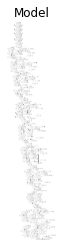

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

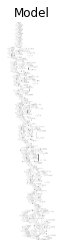

In [16]:
model.summary()
keras.utils.vis_utils.pydot = pydot
plot_model(model,show_shapes=True,to_file='../images/dream_model.png')
img = Image.open('../images/dream_model.png')

plt.figure("Model") # 图像窗口名称
plt.imshow(img)
plt.axis('off') # 关掉坐标轴为 off
plt.title('Model') # 图像题目
plt.show()

In [17]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [18]:
layer_dict=dict([(layer.name, layer) for layer in model.layers])
loss=K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    #将该层特征的 L2 范数添加到 loss中。
    coeff = layer_contributions[layer_name]
    print(coeff)
    activation = layer_dict[layer_name].output
    print(activation)

    # We avoid border artifacts by only involving non-border pixels in the loss.
    #为了避免出现边界伪影，损失中仅包 含非边界的像素
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

0.2
Tensor("mixed2_1/concat:0", shape=(?, ?, ?, 288), dtype=float32)
3.0
Tensor("mixed3_1/concat:0", shape=(?, ?, ?, 768), dtype=float32)
2.0
Tensor("mixed4_1/concat:0", shape=(?, ?, ?, 768), dtype=float32)
1.5
Tensor("mixed5_1/concat:0", shape=(?, ?, ?, 768), dtype=float32)
0.2
Tensor("mixed2_2/concat:0", shape=(?, ?, ?, 288), dtype=float32)
3.0
Tensor("mixed3_2/concat:0", shape=(?, ?, ?, 768), dtype=float32)
2.0
Tensor("mixed4_2/concat:0", shape=(?, ?, ?, 768), dtype=float32)
1.5
Tensor("mixed5_2/concat:0", shape=(?, ?, ?, 768), dtype=float32)


In [19]:
dream=model.input
grads=K.gradients(loss,dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 给定一张输出图像，设置 一个 Keras 函数来获取损失值和梯度值
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x
# 这个函数运行 iterations次梯度上升

In [20]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    #通用函数，用于打开图像、改变图像大小以及将图像格式转换为 Inception V3 模型能够处理的张量
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    #通用函数，将一个张量转换为有效图像
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [21]:
step = 0.01  # Gradient ascent step size（梯度上升的步长）
num_octave = 3  # Number of scales at which to run gradient ascent（运行梯度上升的尺度个数）
octave_scale = 1.4  # Size ratio between scales（两个尺度之间的大小比例）
iterations = 20  # Number of ascent steps per scale（在每个尺度上运行梯度上升的步数）

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
# 如果损失增大到大于 10，我们要中断梯度上升过程，以避免得到丑陋的伪影
max_loss = 10.

# Fill this to the path to the image you want to use
# 将基础图像加载成一个 Numpy 数组
base_image_path = '../data/original_photo_deep_dream.jpg'

# Load the image into a Numpy array
# 将基础图像加载成一个 Numpy 数组
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
# 准备一个由形状元组组成的列表，它定义了运行梯度上升的不同尺度
original_shape = img.shape[1:3]
successive_shapes = [original_shape]


In [22]:
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
# 将形状列表反转，变为升序
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
# 将图像 Numpy 数组的大小缩放到最小尺寸
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='../images/final_dream.png')

Processing image shape (178, 178)
...Loss value at 0 : 0.67178416
...Loss value at 1 : 1.0826428
...Loss value at 2 : 1.5439291
...Loss value at 3 : 2.0623753
...Loss value at 4 : 2.5931342
...Loss value at 5 : 3.1627636
...Loss value at 6 : 3.7382011
...Loss value at 7 : 4.2826633
...Loss value at 8 : 4.8351355
...Loss value at 9 : 5.364257
...Loss value at 10 : 5.9211664
...Loss value at 11 : 6.3710804
...Loss value at 12 : 6.85824
...Loss value at 13 : 7.469489
...Loss value at 14 : 7.910345
...Loss value at 15 : 8.378395
...Loss value at 16 : 8.84373
...Loss value at 17 : 9.438744
...Loss value at 18 : 9.947341
Processing image shape (250, 250)
...Loss value at 0 : 2.1404915
...Loss value at 1 : 3.4663837
...Loss value at 2 : 4.5219693
...Loss value at 3 : 5.4178467
...Loss value at 4 : 6.242865
...Loss value at 5 : 7.1053214
...Loss value at 6 : 7.8176603
...Loss value at 7 : 8.556084
...Loss value at 8 : 9.211701
...Loss value at 9 : 9.916455
Processing image shape (350, 350)
...

KeyboardInterrupt: 

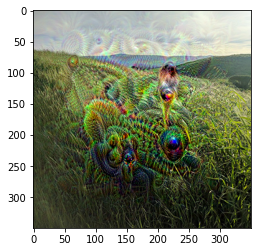

In [ ]:
plt.imshow(deprocess_image(np.copy(img)))
plt.show()